# Analyze plasmid coverage of Ribo-seq reads

## Load libraries

In [1]:
options(warn = -1, repr.matrix.max.rows = 15)

suppressPackageStartupMessages({
  library(rtracklayer)
  library(GenomicAlignments)
  library(plyranges)
  library(tidyverse)
  library(rasilabRtemplates)
})

cbPalette_12 <- c(
  "#DDCC77", "#CC6677", "#6699CC", "#661100", "#117733", "#999933",
  "#332288", "#AA4499", "#44AA99", "#882255", "#88CCEE", "#999999"
)


near_cognate_start_codons <- c("ATG", "CTG", "GTG", "TTG", "ATA", "ATC", "ATT", "AAG", "AGG", "ACG")
names(near_cognate_start_codons) <- near_cognate_start_codons

theme_set(theme_rasilab() +
  theme(
    axis.line = element_line(color = "grey"),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.title.x = element_text(margin = margin(t = 10))
  ))

## Load sample annotations


In [2]:
sample_annotations <- read_csv("../annotations/sample_annotations.csv", show_col_types = F) %>% 
  filter(str_detect(sample_name, "mono")) %>% 
  extract(sample_name, c("sample_name", "replicate"), "(.*)_(.*)") %>% 
  select(sample_id, sample_name, replicate)

sample_annotations

sample_id,sample_name,replicate
<chr>,<chr>,<chr>
225p41,sggcn1_hht_mono,rep1
225p43,sggcn1_dmso_mono,rep1
225p45,sgfluc_hht_mono,rep1
225p47,sgfluc_dmso_mono,rep1
225p61,sggcn1_hht_mono,rep2
225p62,sggcn1_dmso_mono,rep2
225p63,sgfluc_hht_mono,rep2
225p64,sgfluc_dmso_mono,rep2


In [3]:
tx_annotations <- read_gff2("../annotations/plasmids/pHPHS232_pHPHS800_pPNHS189.cleaned.gtf") 

tx_annotations

GRanges object with 32 ranges and 6 metadata columns:
                     seqnames      ranges strand |      source       type
                        <Rle>   <IRanges>  <Rle> |    <factor>   <factor>
   [1] pHPHS232_pHPHS800_pP..   2983-4114      + | rtracklayer transcript
   [2] pHPHS232_pHPHS800_pP..   2983-4114      + | rtracklayer exon      
   [3] pHPHS232_pHPHS800_pP..   2983-3855      + | rtracklayer CDS       
   [4] pHPHS232_pHPHS800_pP..   3856-4114      + | rtracklayer 3'UTR     
   [5] pHPHS232_pHPHS800_pP..  5704-11226      + | rtracklayer transcript
   ...                    ...         ...    ... .         ...        ...
  [28] pHPHS232_pHPHS800_pP.. 28285-29236      + | rtracklayer transcript
  [29] pHPHS232_pHPHS800_pP.. 28285-29236      + | rtracklayer exon      
  [30] pHPHS232_pHPHS800_pP.. 28285-28398      + | rtracklayer 5'UTR     
  [31] pHPHS232_pHPHS800_pP.. 28399-29106      + | rtracklayer CDS       
  [32] pHPHS232_pHPHS800_pP.. 29107-29236      + | rtrackl

In [4]:
tx_gene_names <- tx_annotations %>% 
  filter(type == "transcript") %>% 
  as_tibble() %>% 
  select(transcript_id, gene_id) %>% 
  mutate(gene_name = gene_id, transcript_name = transcript_id)

tx_gene_names

transcript_id,gene_id,gene_name,transcript_name
<chr>,<chr>,<chr>,<chr>
NeoR,NeoR,NeoR,NeoR
Cas9,Cas9,Cas9,Cas9
mcherry,mcherry,mcherry,mcherry
eyfp,eyfp,eyfp,eyfp
bfp,bfp,bfp,bfp
rtta3,rtta3,rtta3,rtta3


In [5]:
tx <- tx_annotations %>% 
  filter(type == "exon") %>% 
  split(.$transcript_id)

tx

GRangesList object of length 6:
$Cas9
GRanges object with 1 range and 6 metadata columns:
                    seqnames     ranges strand |      source     type     score
                       <Rle>  <IRanges>  <Rle> |    <factor> <factor> <numeric>
  [1] pHPHS232_pHPHS800_pP.. 5704-11226      + | rtracklayer     exon        NA
          phase transcript_id     gene_id
      <integer>   <character> <character>
  [1]      <NA>          Cas9        Cas9
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

$NeoR
GRanges object with 1 range and 6 metadata columns:
                    seqnames    ranges strand |      source     type     score
                       <Rle> <IRanges>  <Rle> |    <factor> <factor> <numeric>
  [1] pHPHS232_pHPHS800_pP.. 2983-4114      + | rtracklayer     exon        NA
          phase transcript_id     gene_id
      <integer>   <character> <character>
  [1]      <NA>          NeoR        NeoR
  -------
  seqinfo: 1 sequence from an unspecif

In [6]:
aln <- list.files("../data/alignments/", pattern = "_plasmid.bam$", full.names = T) %>% 
  as_tibble_col("file") %>% 
  mutate(sample_id = str_extract(file, "225p\\d+")) %>% 
  inner_join(sample_annotations, by = "sample_id") %>% 
  mutate(aln = map(file, . %>% readGAlignments %>% as_data_frame)) %>% 
  select(-file) %>% 
  unnest(aln)

aln

sample_id,sample_name,replicate,seqnames,strand,cigar,qwidth,start,end,width,njunc
<chr>,<chr>,<chr>,<fct>,<fct>,<chr>,<int>,<int>,<int>,<int>,<int>
225p41,sggcn1_hht_mono,rep1,pHPHS232_pHPHS800_pPNHS189,+,60M,60,552,611,60,0
225p41,sggcn1_hht_mono,rep1,pHPHS232_pHPHS800_pPNHS189,+,57M,57,796,852,57,0
225p41,sggcn1_hht_mono,rep1,pHPHS232_pHPHS800_pPNHS189,+,31M,31,1372,1402,31,0
225p41,sggcn1_hht_mono,rep1,pHPHS232_pHPHS800_pPNHS189,+,31M,31,1687,1717,31,0
225p41,sggcn1_hht_mono,rep1,pHPHS232_pHPHS800_pPNHS189,+,24M,24,1745,1768,24,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
225p64,sgfluc_dmso_mono,rep2,pHPHS232_pHPHS800_pPNHS189,+,30M,30,30303,30332,30,0
225p64,sgfluc_dmso_mono,rep2,pHPHS232_pHPHS800_pPNHS189,+,27M,27,30308,30334,27,0
225p64,sgfluc_dmso_mono,rep2,pHPHS232_pHPHS800_pPNHS189,+,29M,29,30312,30340,29,0


In [7]:
aln_counts <- aln %>% 
  GRanges() %>% 
  filter(width >= 27, width <= 33) %>% 
  # we remove an extra nt so that we can look for overlap with any 3 nt in the codon
  narrow(start = 15, width = 1)

aln_counts <- aln_counts %>%
  GenomicFeatures::mapToTranscripts(tx) %>%
  as_tibble() %>%
  mutate(sample_name = aln_counts[xHits]$sample_name) %>%
  select(-xHits, -transcriptsHits) %>% 
  as_tibble() %>% 
  group_by(seqnames, start, end, sample_name) %>%
  summarize(score = sum(width), .groups = "drop") %>%
  ungroup() %>% 
  mutate(psite = start) %>%
  GRanges() %>%
  print()

GRanges object with 8929 ranges and 3 metadata columns:
         seqnames    ranges strand |      sample_name     score     psite
            <Rle> <IRanges>  <Rle> |      <character> <integer> <integer>
     [1]     Cas9        14      * |  sgfluc_hht_mono         2        14
     [2]     Cas9        15      * |  sggcn1_hht_mono         1        15
     [3]     Cas9        16      * |  sgfluc_hht_mono         2        16
     [4]     Cas9        19      * |  sgfluc_hht_mono         5        19
     [5]     Cas9        20      * |  sgfluc_hht_mono        10        20
     ...      ...       ...    ... .              ...       ...       ...
  [8925]    rtta3       823      * | sggcn1_dmso_mono         3       823
  [8926]    rtta3       832      * |  sgfluc_hht_mono         2       832
  [8927]    rtta3       834      * | sgfluc_dmso_mono         1       834
  [8928]    rtta3       839      * |  sgfluc_hht_mono         1       839
  [8929]    rtta3       840      * |  sggcn1_hht_mono   

In [8]:
genome <- readDNAStringSet("../annotations/plasmids/pHPHS232_pHPHS800_pPNHS189.fa") %>% 
  unlist() %>% 
  print()

30476-letter DNAString object
seq: TGCAGCTCTGGCCCGTGTCTCAAAATCTCTGATGTT...GTCAGAGGTTTTCACCGTCATCACCGAAACGCGCGA


In [9]:
tx_seq <- GenomicFeatures::extractTranscriptSeqs(genome, as(tx, "IntegerRangesList")) %>% 
  print()

DNAStringSet object of length 6:
    width seq                                               names               
[1]  5523 GTCAGATCGCCTGGAGCAATTCC...AACCATTATAAGCTGCAATAAAC Cas9
[2]  1132 GGCCTCGAGAGATCTGGCAGCGG...TGGGGATGCGGTGGGCTCTATGG NeoR
[3]  3029 GCCACCATGGTGTCTAAGGGCGA...GTCCCTCTTCTCTTATGGAGATC bfp
[4]  1094 AATTCAGATCGCCTGGAGCAATT...TGGGGATGCGGTGGGCTCTATGG eyfp
[5]  1625 CTTTTTCGCAACGGGTTTGCCGC...AACCATTATAAGCTGCAATAAAC mcherry
[6]   952 GATCGCCTGGAGACGCCATCCAC...AACCATTATAAGCTGCAATAAAC rtta3


In [10]:
start_codons_tx <- tx_annotations %>% 
  filter(type == "start_codon") %>% 
  GenomicFeatures::mapToTranscripts(tx) %>%
  as_tibble() %>% 
  select(seqnames, start, end) %>%
  print()

# A tibble: 1 × 3
  seqnames start   end
  <fct>    <int> <int>
1 eyfp        60    62


In [11]:
utr_cds_annotations <- tx_annotations %>% 
  filter(type %in% c("UTR", "CDS")) 

utr_cds_length <- utr_cds_annotations %>%
  GenomicFeatures::mapToTranscripts(tx) %>%
  as_tibble() %>% 
  mutate(type = utr_cds_annotations$type[xHits]) %>%
  left_join(start_codons_tx, by = "seqnames", suffix = c("", "_start")) %>%
  left_join(tx_gene_names, by = c("seqnames" = "transcript_id")) %>%
  mutate(type = case_when(
    type == "UTR" & start < start_start ~ "UTR5",
    type == "UTR" & start > start_start ~ "UTR3",
    TRUE ~ "CDS"
  )) %>%
  group_by(gene_name, type) %>%
  summarize(start = min(start), .groups = "drop") %>%
  print()

# A tibble: 6 × 3
  gene_name type  start
  <chr>     <chr> <int>
1 bfp       CDS       7
2 Cas9      CDS     100
3 eyfp      CDS      60
4 mcherry   CDS     106
5 NeoR      CDS       1
6 rtta3     CDS     115


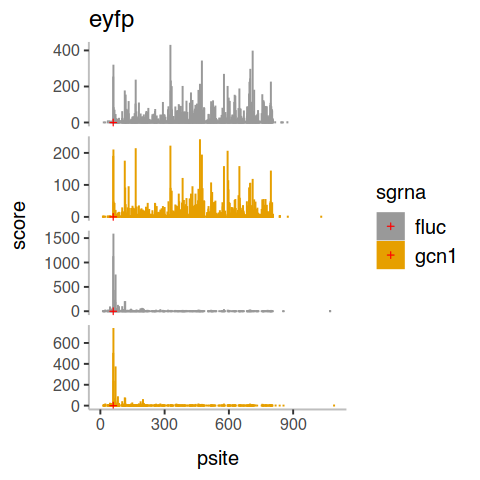

In [12]:
options(repr.plot.width = 4, repr.plot.height = 4)

gene <- "eyfp"

plot_data <- aln_counts %>%
  as_tibble() %>%
  left_join(tx_gene_names, by = c("seqnames" = "transcript_id")) %>%
  filter(gene_name == gene)

tx_width <- tx_gene_names %>%
  filter(gene_name == gene) %>%
  pull(transcript_id) %>%
  tx_seq[.] %>%
  width()

plot_data <- tx_width %>%
  seq(1, .) %>%
  as_tibble_col(column_name = "start") %>%
  left_join(plot_data, by = "start") %>% 
  complete(sample_name, start) %>%
  mutate(score = ifelse(is.na(score), 0, score)) %>%
  filter(!is.na(sample_name)) %>%
  mutate(drug = str_extract(sample_name, "dmso|hht")) %>%
  mutate(sgrna = str_extract(sample_name, "gcn1|fluc"))

gene_plot <- plot_data  %>%
  inner_join(utr_cds_length, by = c("psite" = "start", "gene_name"))


plot_data %>%
  ggplot(aes(x = psite, y = score, fill = sgrna, color = sgrna)) +
  facet_wrap(~ drug + sgrna, scales = "free_y", ncol = 1) +
  geom_col() +
  geom_point(aes(x = psite, y = 0), size = 1, shape = "plus", color = "red", data = gene_plot, vjust = 1, hjust = 0.5) +
  labs(title = gene) +
  theme(strip.text.x = element_blank(),
  #   axis.title.y = element_blank(),
  # axis.text.y = element_blank(),
  # axis.ticks.y = element_blank(),
  # axis.line.y = element_blank()
  ) +
  scale_x_continuous(limits=c(1, tx_width)) +
  scale_y_continuous(breaks = scales::pretty_breaks(n=3))

ggsave("../figures/eyfp_riboseq.pdf", width = 4, height = 4)
